In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from krippendorff import alpha

sns.set_theme(style="whitegrid", context="paper", font_scale=1.3)

In [2]:
res = pd.read_csv("results.csv", sep=";", header=None)

In [3]:
res_t = res.T
res_t.columns = ["Run", "Prompt", "Model", "Score1", "Score2", "Score3", "Score4"]
res_t["Score1"] = res_t["Score1"].astype(float)
res_t["Score2"] = res_t["Score2"].astype(float)
res_t["Score3"] = res_t["Score3"].astype(float)
res_t["Score4"] = res_t["Score4"].astype(float)

res_t["Score"] = res_t[["Score1", "Score2", "Score3", "Score4"]].mean(axis=1)

## Krippendorff alpha

In [20]:
kr = res.drop([0,1,2])
kr = kr.astype(float)

alpha(kr.values, level_of_measurement="ordinal", value_domain=[1,2,3,4,5])

0.4650998138665381

## RQ 1

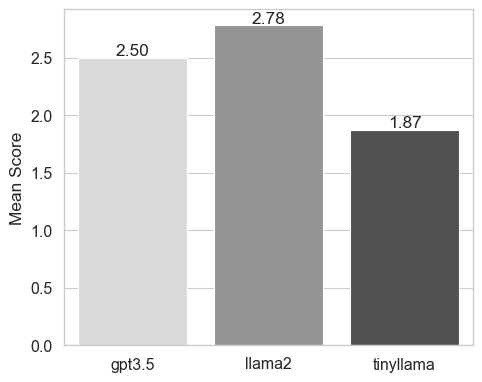

In [5]:
rq1 = res_t.pivot_table(
    index="Run", columns=["Model"], values=["Score"], aggfunc="mean"
)
fig, ax = plt.subplots(figsize=(5,4))
ax = sns.barplot(data=rq1.agg("mean").reset_index(), x="Model", y=0, hue='Model', palette="Greys")
plt.ylabel("Mean Score")
plt.xlabel("")
plt.xticks([0, 1, 2], ["gpt3.5", "llama2", "tinyllama"])

for p in ax.patches:
    if not p.get_height() == 0.0:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
        )
    # p.set_hatch(hatch)
plt.tight_layout()
plt.savefig("figures/rq1.pdf")

## RQ 2

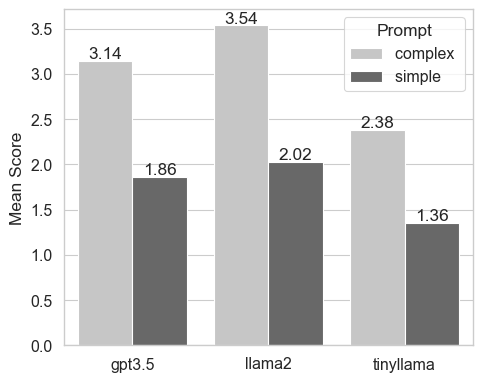

In [6]:
rq2 = res_t.pivot_table(
    index="Run", columns=["Model", "Prompt"], values=["Score"], aggfunc="mean"
)
fig, ax = plt.subplots(figsize=(5,4))
ax = sns.barplot(
    data=rq2.agg("mean").reset_index(), 
    x="Model", 
    y=0, 
    hue="Prompt",
    palette="Greys")
# show values on top of bars
for p in ax.patches:
    if not p.get_height()==0.0:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
        )
sns.move_legend(ax, "upper right", frameon=True)
plt.ylabel("Mean Score")
plt.xlabel("")
plt.xticks([0, 1, 2], ["gpt3.5", "llama2", "tinyllama"])
plt.tight_layout()
plt.savefig("figures/rq2.pdf")

## RQ 3

In [7]:
rq3 = res_t.pivot_table(columns=["Model", "Prompt", "Run"], values=["Score"], aggfunc="mean")

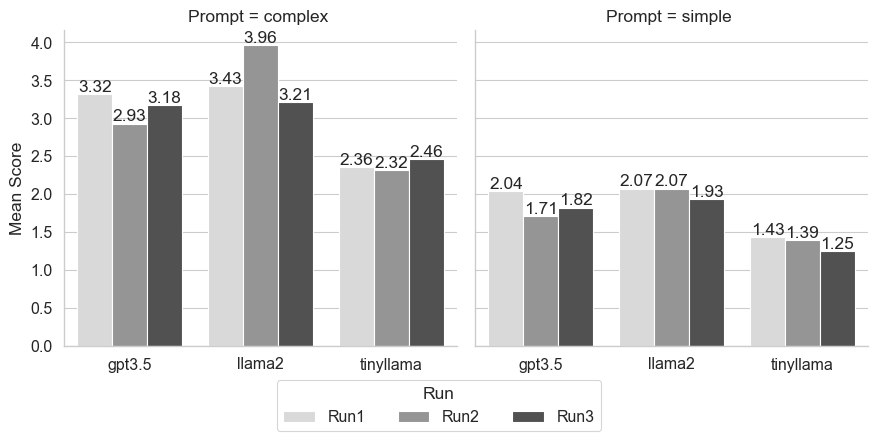

In [8]:
grid = sns.catplot(
    data=rq3.aggregate("mean").reset_index(),
    x="Model",
    y=0,
    hue="Run",
    col="Prompt",
    kind="bar",
    height=4,
    palette="Greys",
)
grid.set_axis_labels("", "Mean Score")

# show values on top of bars
for ax in grid.axes.flat:
    for p in ax.patches:
        if not p.get_height()==0.0:
            ax.annotate(
                f"{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center",
                va="center",
                xytext=(0, 5),
                textcoords="offset points",
            )
sns.move_legend(grid, "lower center", ncol=3, frameon=True, bbox_to_anchor=(0.5, -0.12))
grid.set_xticklabels(["gpt3.5", "llama2", "tinyllama"])
plt.tight_layout()
plt.savefig("figures/rq3.pdf", bbox_inches="tight")

## RQ4

In [11]:
iterative = pd.read_csv("results_iterative_new.csv", sep=';', header=None)
iterative = iterative.T
iterative.columns = ["Iterations", "Score1", "Score2", "Score3", "Score4"]
iterative["Score"] = iterative[["Score1", "Score2", "Score3", "Score4"]].mean(axis=1)
rq4 = iterative.groupby("Iterations")["Score"].mean()

In [12]:
rq4

Iterations
3     3.857143
10    3.571429
Name: Score, dtype: float64

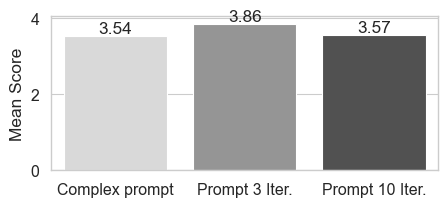

In [13]:
fig, ax = plt.subplots(figsize=(5,2))
sns.barplot(
    x=["Complex prompt", "Prompt 3 Iter.", "Prompt 10 Iter."],
    hue=["Complex prompt", "Prompt 3 Iter.", "Prompt 10 Iter."],
    y=[3.54, 3.86, 3.57],
    palette="Greys",
    ax=ax,
)
for p in ax.patches:
    if not p.get_height() == 0.0:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
        )
plt.ylabel("Mean Score")
# plt.xticks(rotation=45)
# plt.xlabel("Prompt Style")
plt.savefig("figures/rq4.pdf", bbox_inches='tight')
plt.show()